In [71]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import t, norm
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

In [16]:
#problem1

In [17]:
df = pd.read_csv("DailyPrices.csv", index_col="Date", parse_dates=True)

In [18]:
stocks = ["SPY", "AAPL", "EQIX"]
data = df[stocks]

In [19]:
#Part A
arithmetic_returns = data.pct_change().dropna()
arithmetic_returns -= arithmetic_returns.mean()
total_std_arithmetic = np.sqrt((arithmetic_returns**2).sum().sum() / (arithmetic_returns.size - 1))

print("Arithmetic Returns - Last 5 Rows:")
print(arithmetic_returns.tail())
print("Total Standard Deviation (Arithmetic Returns):", total_std_arithmetic)

Arithmetic Returns - Last 5 Rows:
                 SPY      AAPL      EQIX
Date                                    
2024-12-27 -0.011492 -0.014678 -0.006966
2024-12-30 -0.012377 -0.014699 -0.008064
2024-12-31 -0.004603 -0.008493  0.006512
2025-01-02 -0.003422 -0.027671  0.000497
2025-01-03  0.011538 -0.003445  0.015745
Total Standard Deviation (Arithmetic Returns): 0.012679754664908071


In [20]:
#Part B: Calculate Log Returns
log_returns = np.log(data / data.shift(1)).dropna()
log_returns -= log_returns.mean()
total_std_log = np.sqrt((log_returns**2).sum().sum() / (log_returns.size - 1))

print("\nLog Returns - Last 5 Rows:")
print(log_returns.tail())
print("Total Standard Deviation (Log Returns):", total_std_log)


Log Returns - Last 5 Rows:
                 SPY      AAPL      EQIX
Date                                    
2024-12-27 -0.011515 -0.014675 -0.006867
2024-12-30 -0.012410 -0.014696 -0.007972
2024-12-31 -0.004577 -0.008427  0.006602
2025-01-02 -0.003392 -0.027930  0.000613
2025-01-03  0.011494 -0.003356  0.015725
Total Standard Deviation (Log Returns): 0.01263076561554221


In [21]:
#problem2

In [22]:
#Part A: Calculate Portfolio Value for 1/3/2025
holdings = np.array([100, 200, 150])
portfolio_value = (data.loc["2025-01-03"] * holdings).sum()
print("Portfolio Value on 1/3/2025:", portfolio_value)

Portfolio Value on 1/3/2025: 251862.4969482422


In [80]:
#Part B: Calculate VaR and ES at 5% level using different methods

def calculate_var_es_normal(returns, holdings, alpha=0.05, lambda_=0.97):
    centered_returns = returns - returns.mean()
    cov_matrix = centered_returns.ewm(span=(2/(1-lambda_)-1)).cov(pairwise=True).iloc[-len(holdings):]
    port_variance = np.dot(holdings, np.dot(cov_matrix, holdings))
    port_std = np.sqrt(port_variance)
    var_stocks = norm.ppf(alpha) * centered_returns.std()
    es_stocks = -centered_returns.std() * norm.pdf(norm.ppf(alpha)) / alpha
    var_portfolio = norm.ppf(alpha) * port_std
    es_portfolio = -port_std * norm.pdf(norm.ppf(alpha)) / alpha
    return var_stocks, es_stocks, var_portfolio, es_portfolio

def calculate_var_es_t_copula(returns, holdings, alpha=0.05):
    centered_returns = returns - returns.mean()
    t_params = [t.fit(centered_returns[col]) for col in centered_returns.columns]
    simulated_returns = np.array([t.ppf(np.random.uniform(size=len(centered_returns)), *params) - t.mean(*params) for params in t_params]).T
    portfolio_returns = np.dot(simulated_returns, holdings)
    var_stocks = centered_returns.quantile(alpha)
    es_stocks = centered_returns[centered_returns <= var_stocks].mean()
    var_portfolio = np.percentile(portfolio_returns, alpha * 100)
    es_portfolio = portfolio_returns[portfolio_returns <= var_portfolio].mean()
    return var_stocks, es_stocks, var_portfolio, es_portfolio

def calculate_var_es_historical(returns, holdings, alpha=0.05):
    centered_returns = returns - returns.mean()
    portfolio_returns = (centered_returns * holdings).sum(axis=1)
    var_stocks = centered_returns.quantile(alpha)
    es_stocks = centered_returns[centered_returns <= var_stocks].mean()
    var_portfolio = np.percentile(portfolio_returns, alpha * 100, interpolation='lower')
    es_portfolio = portfolio_returns[portfolio_returns <= var_portfolio].mean()
    return var_stocks, es_stocks, var_portfolio, es_portfolio

def calculate_returns(data):
    return data.pct_change().dropna()

stocks = ["SPY", "AAPL", "EQIX"]
holdings = np.array([100, 200, 150])

returns = calculate_returns(data)

alpha = 0.05
var_stocks_normal, es_stocks_normal, var_portfolio_normal, es_portfolio_normal = calculate_var_es_normal(returns, holdings, alpha)
print("Method 1: Normally distributed with exponentially weighted covariance")
for stock in stocks:
    print(f"{stock} VaR: {var_stocks_normal[stock]:.6f}, {stock} ES: {es_stocks_normal[stock]:.6f}")
print(f"Portfolio VaR: {var_portfolio_normal:.6f}, Portfolio ES: {es_portfolio_normal:.6f}")
print()

var_stocks_t, es_stocks_t, var_portfolio_t, es_portfolio_t = calculate_var_es_t_copula(returns, holdings, alpha)
print("Method 2: T-distribution using a Gaussian Copula")
for stock in stocks:
    print(f"{stock} VaR: {var_stocks_t[stock]:.6f}, {stock} ES: {es_stocks_t[stock]:.6f}")
print(f"Portfolio VaR: {var_portfolio_t:.6f}, Portfolio ES: {es_portfolio_t:.6f}")
print()

var_stocks_hist, es_stocks_hist, var_portfolio_hist, es_portfolio_hist = calculate_var_es_historical(returns, holdings, alpha)
print("Method 3: Historic simulation using the full history")
for stock in stocks:
    print(f"{stock} VaR: {var_stocks_hist[stock]:.6f}, {stock} ES: {es_stocks_hist[stock]:.6f}")
print(f"Portfolio VaR: {var_portfolio_hist:.6f}, Portfolio ES: {es_portfolio_hist:.6f}")

Method 1: Normally distributed with exponentially weighted covariance
SPY VaR: -0.013285, SPY ES: -0.016660
AAPL VaR: -0.022177, AAPL ES: -0.027811
EQIX VaR: -0.025266, EQIX ES: -0.031684
Portfolio VaR: -6.576392, Portfolio ES: -8.247061

Method 2: T-distribution using a Gaussian Copula
SPY VaR: -0.014738, SPY ES: -0.018247
AAPL VaR: -0.021925, AAPL ES: -0.029540
EQIX VaR: -0.025244, EQIX ES: -0.032743
Portfolio VaR: -5.504036, Portfolio ES: -7.562423

Method 3: Historic simulation using the full history
SPY VaR: -0.014738, SPY ES: -0.018247
AAPL VaR: -0.021925, AAPL ES: -0.029540
EQIX VaR: -0.025244, EQIX ES: -0.032743
Portfolio VaR: -7.929037, Portfolio ES: -9.909338


/var/folders/30/4j0_qfq56ll_fl0_jwr614tc0000gn/T/ipykernel_90878/414259222.py:57: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  var_stocks_hist, es_stocks_hist, var_portfolio_hist, es_portfolio_hist = calculate_var_es_historical(returns, holdings, alpha)


In [74]:
#problem3

In [75]:
S = 31
K = 30
T = 0.25
r = 0.10
C_market = 3.00
sigma_initial = 0.2
trading_days = 255
alpha = 0.05
holding_period = 20
annual_vol = 0.25

In [76]:
# Black-Scholes Call Price function
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)
    return call_price

In [77]:
#Part A: Implied Volatility Calculation using root finding
def implied_volatility(S, K, T, r, C_market):
    func = lambda sigma: black_scholes_call(S, K, T, r, sigma) - C_market
    result = root_scalar(func, bracket=[0.01, 2.0], method='brentq')
    return result.root if result.converged else np.nan

sigma_iv = implied_volatility(S, K, T, r, C_market)
print(f"Implied Volatility: {sigma_iv}")


Implied Volatility: 0.3350803924787905


In [78]:
#Part B. Calculate Greeks
def black_scholes_greeks(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    delta = stats.norm.cdf(d1)
    vega = S * stats.norm.pdf(d1) * np.sqrt(T)
    theta = - (S * stats.norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - r * K * np.exp(-r * T) * stats.norm.cdf(d2)
    
    return delta, vega, theta

delta, vega, theta = black_scholes_greeks(S, K, T, r, sigma_iv)
print(f"Delta: {delta}, Vega: {vega}, Theta: {theta}")

# Option price change due to 1% increase in implied volatility
sigma_new = sigma_iv + 0.01
call_price_new = black_scholes_call(S, K, T, r, sigma_new)
call_price_change = call_price_new - C_market
print(f"Change in Call Price due to 1% IV increase: {call_price_change}")

Delta: 0.6659296527386921, Vega: 5.640705439230117, Theta: -5.544561508358898
Change in Call Price due to 1% IV increase: 0.056498427517343686


In [79]:
# C. Generalized Black-Scholes-Merton Put Price and Put-Call Parity
put_price = black_scholes_call(S, K, T, r, sigma_iv) - S + K * np.exp(-r * T)
print(f"Put Price: {put_price}")

# Check Put-Call Parity
put_call_parity = C_market + K * np.exp(-r * T) - S
print(f"Put-Call Parity Difference: {abs(put_price - put_call_parity)}")

Put Price: 1.259297360849974
Put-Call Parity Difference: 3.552713678800501e-15


In [69]:
# D. VaR and ES Calculations
S = 31
K = 30
T = 0.25
C_market = 3.00
P_market = 1.2593
r = 0.10
volatility_stock = 0.25
alpha = 0.05
holding_days = 20
trading_days = 255

volatility_holdings = volatility_stock * np.sqrt(holding_days / trading_days)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

def black_scholes_theta(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    theta_call = (- (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) 
                  - r * K * np.exp(-r * T) * norm.cdf(d2)) / trading_days
    
    theta_put = (- (S * norm.pdf(d1) * sigma) / (2 * np.sqrt(T)) 
                 + r * K * np.exp(-r * T) * norm.cdf(-d2)) / trading_days
    
    return theta_call, theta_put

theta_call, theta_put = black_scholes_theta(S, K, T, r, sigma_iv)
theta_total = theta_call + theta_put
option_value_decay = theta_total * holding_days

portfolio_value = S + C_market + P_market + option_value_decay

z_score = norm.ppf(1 - alpha)
VaR_delta_normal = -z_score * portfolio_value * volatility_holdings
ES_delta_normal = -portfolio_value * volatility_holdings * norm.pdf(z_score) / alpha

print("VaR Delta-Normal Approximation:", round(VaR_delta_normal, 3))
print("ES Delta-Normal Approximation:", round(ES_delta_normal, 3))

simulations = 100000

stock_returns = np.random.normal(-0.5 * volatility_stock**2 / trading_days, volatility_holdings, (simulations, holding_days))

price_paths = S * np.exp(stock_returns.cumsum(axis=1))

decay_paths = black_scholes_call(price_paths[:, -1], K, T - holding_days / trading_days, r, sigma_iv) + \
              black_scholes_put(price_paths[:, -1], K, T - holding_days / trading_days, r, sigma_iv)

portfolio_paths = price_paths[:, -1] + decay_paths
portfolio_returns = (portfolio_paths - portfolio_value) / portfolio_value

VaR_monte_carlo = -np.percentile(portfolio_returns, alpha * 100)
ES_monte_carlo = -portfolio_returns[portfolio_returns <= -VaR_monte_carlo].mean()

print("VaR Monte Carlo Simulation:", round(VaR_monte_carlo, 3))
print("ES Monte Carlo Simulation:", round(ES_monte_carlo, 3))



VaR Delta-Normal Approximation: -3.987
ES Delta-Normal Approximation: -5.0
VaR Monte Carlo Simulation: 0.148
ES Monte Carlo Simulation: 0.148


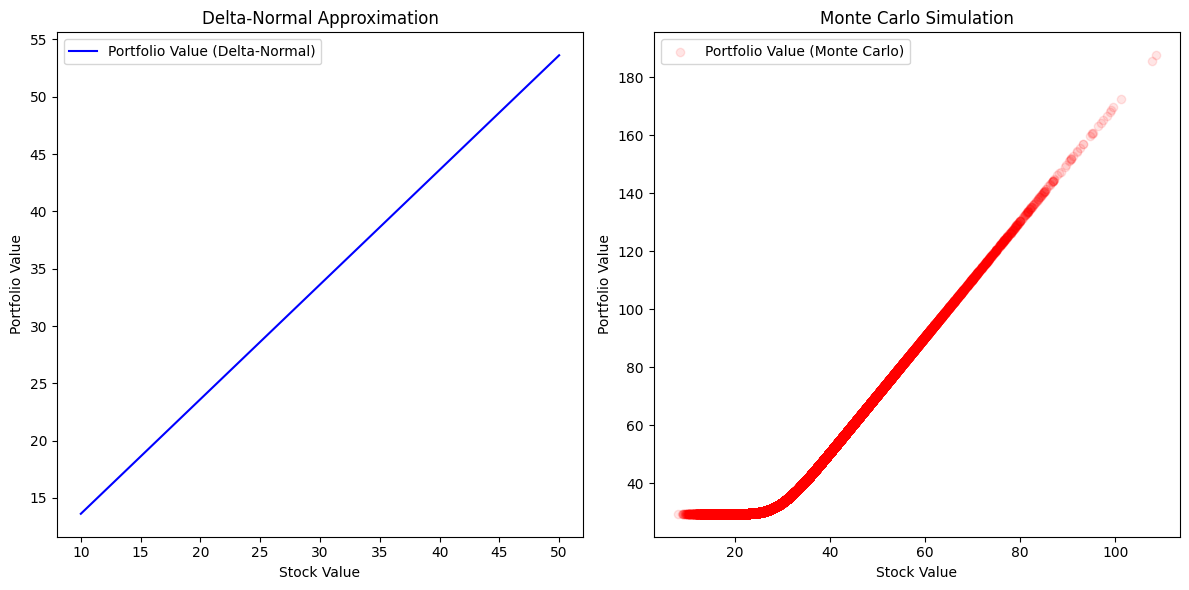

In [70]:
# E. Portfolio Value vs Stock Price
# Graph the portfolio value vs stock value for both methods
stock_prices = np.linspace(10, 50, 100)

# Delta-Normal Approximation (portfolio value as a function of stock price)
portfolio_values_dn = stock_prices + C_market + P_market + option_value_decay

# Monte Carlo Simulation (portfolio value)
final_price_paths = price_paths[:, -1]
decay_paths_mc = black_scholes_call(final_price_paths, K, T - holding_days / trading_days, r, sigma_iv) + \
                 black_scholes_put(final_price_paths, K, T - holding_days / trading_days, r, sigma_iv)
portfolio_values_mc = final_price_paths + decay_paths_mc

plt.figure(figsize=(12, 6))

# Delta-Normal Approximation
plt.subplot(1, 2, 1)
plt.plot(stock_prices, portfolio_values_dn, label='Portfolio Value (Delta-Normal)', color='blue')
plt.xlabel('Stock Value')
plt.ylabel('Portfolio Value')
plt.title('Delta-Normal Approximation')
plt.legend()

# Monte Carlo Simulation
plt.subplot(1, 2, 2)
plt.scatter(final_price_paths, portfolio_values_mc, label='Portfolio Value (Monte Carlo)', color='red', alpha=0.1)
plt.xlabel('Stock Value')
plt.ylabel('Portfolio Value')
plt.title('Monte Carlo Simulation')
plt.legend()

plt.tight_layout()
plt.show()
